In [1]:
from __future__ import print_function
import os
import sys
from test_arg_utils import *

sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], "src"))

from pkg.utils.test_scripts import *
from pkg.planning.pddlstream.plan_rnb import *

rtype = "panda"
dat_root = "stowing-deep"
res_root = "stowing-deep-result"
dat_dir = "20210917-113211"
file_option = "obj_3c_obs7"
data_idx = 1
cname = "ToolReach"

GRASP_SAMPLE = 30
STABLE_SAMPLE = 50

IK_TIMEOUT_SINGLE = 0.01
IK_TRY_NUM = 10
TIMEOUT_MOTION = 3
MAX_TIME = 100

MAX_ITER = 100
MAX_SKELETONS = 30
SEARCH_SAMPLE_RATIO = 100

USE_MOVEIT_IK = True
TIMED_COMPLETE = False

VERBOSE = True
VISUALIZE = True
PLAY_RESULT = True
SHOW_STATE = False
USE_PYBULLET_GUI = False
SAVE_RESULTS = False
STACK_TIMELOG= True


CLEARANCE = 1e-3
TOOL_NAME="grip0"
ROBOT_TYPE = {e.name: e for e in RobotType}[rtype]

[WARN] Motion Planning Logging is ON


In [2]:

########################################################
################### Create data folders ################
DATASET_PATH = create_data_dirs(dat_root, rtype, dat_dir)
RESULTSET_PATH = create_data_dirs(res_root, rtype, dat_dir)
print("-"*50)
print("DATASET_PATH: {}".format(DATASET_PATH))
print("RESULTSET_PATH: {}".format(RESULTSET_PATH))
print("-"*50)


########################################################
########## Load scene and prepare planner  #############
ROBOT_NAME, TOOL_LINK, TOOL_XYZ, TOOL_RPY, HOME_POSE, GRIP_DEPTH = get_single_robot_params(ROBOT_TYPE)
s_builder, pscene = prepare_single_robot_scene(ROBOT_TYPE, ROBOT_NAME, TOOL_LINK, TOOL_XYZ, TOOL_RPY, VISUALIZE=VISUALIZE)
crob, gscene = pscene.combined_robot, pscene.gscene
crob.home_pose = HOME_POSE
crob.home_dict = list2dict(HOME_POSE, gscene.joint_names)

fname = "data_%s_%02d.pkl" % (file_option, data_idx)
print(fname)
set_meta_data("dat_root", dat_root)
set_meta_data("rtype", rtype)
set_meta_data("dat_dir", dat_dir)
set_meta_data("fname", fname)


file_gtems = os.path.join(DATASET_PATH, fname)
initial_state = load_saved_scene(pscene, file_gtems, VISUALIZE=VISUALIZE)

gscene.NAME_DICT['obj_0'].color = (1,0,0,1)
gscene.update_markers_all()

mplan = MoveitPlanner(pscene)
checkers = get_checkers_by_case_name(cname, pscene)

mplan.motion_filters = checkers


--------------------------------------------------
DATASET_PATH: /home/rnb/Projects/rnb-planning/data/stowing-deep/panda/20210917-113211
RESULTSET_PATH: /home/rnb/Projects/rnb-planning/data/stowing-deep-result/panda/20210917-113211
--------------------------------------------------
connection command:
panda0: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
data_obj_3c_obs7_01.pkl


## Edit scene

In [3]:
for i in range(7):
    gscene.remove(gscene.NAME_DICT["obs{}".format(i)])

In [4]:
obj0 = pscene.subject_dict['obj_0']
obj1 = pscene.subject_dict['obj_1']
obj2 = pscene.subject_dict['obj_2']

del obj0.action_points_dict["obj_0_side_g"].redundancy['x']
obj0.action_points_dict["obj_0_side_g"].redundancy['u'] = (np.pi*3/4, np.pi*5/4)
del obj1.action_points_dict["obj_1_side_g"].redundancy['x']
obj1.action_points_dict["obj_1_side_g"].redundancy['u'] = (np.pi*3/4, np.pi*5/4)
del obj2.action_points_dict["obj_2_side_g"].redundancy['x']
obj2.action_points_dict["obj_2_side_g"].redundancy['u'] = (np.pi*3/4, np.pi*5/4)

obj0.action_points_dict['bottom_p'].redundancy = {}
obj1.action_points_dict['bottom_p'].redundancy = {}
obj2.action_points_dict['bottom_p'].redundancy = {}

wpa=pscene.actor_dict['wp']
del wpa.redundancy["w"]
gpa=pscene.actor_dict['gp']
del gpa.redundancy["w"]

grip0 = pscene.actor_dict['grip0']
grip0.redundancy = {}
# grip0.redundancy = ['w'] = (-0.01,0.01)

In [5]:
pscene.set_object_state(initial_state)
gscene.update_markers_all()

wp = gscene.NAME_DICT["wp"]
wp.set_offset_tf(center=np.add(wp.center, (0,0,0.4)))
wpa.update_handle()
wpb = gscene.NAME_DICT["wp_bot"]
wpb.dims = np.subtract(wpb.dims, (0.1, 0.1, 0.0))
wpb.set_offset_tf(center=np.add(wpb.center, (0,0,0.4)))
wp_ceil = gscene.copy_from(wp, new_name="wp_ceil")
wp_ceil.set_offset_tf(center = np.add(wp.center, (0,0,0.3)))

gp = gscene.NAME_DICT["gp"]
gp.set_offset_tf(center=np.add(gp.center, (0,0,0.2)))
gpa.update_handle()
gpb = gscene.NAME_DICT["gp_bot"]
gpb.set_offset_tf(center=np.add(gpb.center, (0,0,0.2)))

gscene.update_markers_all()

In [6]:
# pscene.remove_subject("obj_1")
# gscene.remove(gscene.NAME_DICT["obj_1"])

pscene.remove_subject("obj_2")
gscene.remove(gscene.NAME_DICT["obj_2"])

In [7]:
# obj0.set_offset_tf(center=[0.29480234, 0.59536386, 0.1798489])
sprm = obj0.get_state_param()
T = sprm[1]
T[:3,:3] = np.identity(3)
T[:3,3] = [0.20, 0.50, 0.1798489+0.4]
obj0.set_state(obj0.binding, sprm)

sprm = obj1.get_state_param()
T = sprm[1]
T[:3,:3] = np.identity(3)
T[:3,3] = (0.15, 0.45, 0.1798489+0.4)
obj1.set_state(obj1.binding, sprm)

# sprm = obj2.get_state_param()
# T = sprm[1]
# T[:3,:3] = np.identity(3)
# T[:3,3] = (0.40, 0.25, 0.1798489+0.4)
# obj2.set_state(obj2.binding, sprm)

initial_state = pscene.initialize_state(initial_state.Q, force_fit_binding=True)
gscene.update_markers_all()

In [8]:
GRASP_SAMPLE = 10
STABLE_SAMPLE = 20
SEARCH_SAMPLE_RATIO = 100
MAX_TIME = 300

In [9]:
VERBOSE = True
VISUALIZE = True
PLAY_RESULT = True
SHOW_STATE = False

In [10]:
from pkg.planning.motion.interface import MOTION_PATH

In [13]:
mfiles = sorted(os.listdir(MOTION_PATH))

In [83]:
# for mfile in mfiles:
if True:
    mfile = mfiles[1]
    mdat = load_pickle(os.path.join(MOTION_PATH, mfile))

    from_state = mdat['from_state']
    to_state = mdat['to_state']
    btf_dict = mdat['btf_dict']
    binding_list = mdat['binding_list']
    success = mdat['success']
    Traj = mdat['Traj']

    pscene.set_object_state(from_state)
    gscene.update_markers_all()
    gscene.show_pose(from_state.Q)
    time.sleep(0.5)
    gscene.show_pose(to_state.Q)

    bd_list, succ = pscene.get_slack_bindings(from_state, to_state)
    for bd in bd_list:
        pass


    print("success: {} / {}".format(success, mplan.validate_trajectory(Traj)))
    if success:
        gscene.show_motion(Traj, period=0.01)

success: False / True


In [84]:
mplan.validate_trajectory([from_state.Q]), mplan.validate_trajectory([to_state.Q])

(True, True)

In [93]:
newQ = to_state.Q + [0,0,0,0,0,0,0]
gscene.show_pose(newQ)
print(mplan.validate_trajectory([newQ]))

True


In [123]:
newQ = to_state.Q + [-0.05,-0.2,0,0,0,0,0]
gscene.show_pose(newQ)
print(mplan.validate_trajectory([newQ]))

True


In [124]:
to_state_n = to_state.copy(pscene)
to_state_n.Q = newQ

In [130]:
traj1, lQ, err, succ = mplan.plan_algorithm(from_state, to_state_n, [], btf_dict, timeout=1)
print(succ)

True


In [131]:
traj2, lQ, err, succ = mplan.plan_algorithm(to_state_n, to_state, [], btf_dict, timeout=1)
print(succ)

False


In [134]:
traj_new = (np.arange(100).astype(np.float)/100)[:, np.newaxis]*(to_state.Q - newQ)[np.newaxis, :]+newQ

In [135]:
gscene.show_motion(traj_new)

In [138]:
traj_cat = np.concatenate([traj1, traj_new])
mplan.validate_trajectory(traj_cat)

True

In [141]:
gscene.show_motion(traj_cat)

In [142]:
import matplotlib.pyplot as plt

In [144]:
jlims = crob.get_joint_limits()

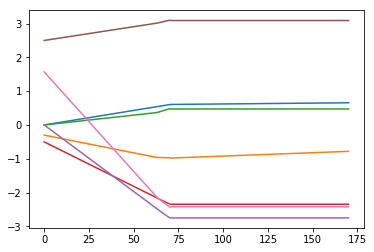

In [143]:
plt.plot(traj_cat)

In [117]:
gscene.highlight_robot()

{'grip0': (True, (1, 0, 0, 1)),
 'panda0_hand_Box_1': (False, (0, 1, 0, 0.5)),
 'panda0_hand_Box_2': (False, (0, 1, 0, 0.5)),
 'panda0_hand_Box_3': (False, (0, 1, 0, 0.5)),
 'panda0_hand_Box_4': (False, (0, 1, 0, 0.5)),
 'panda0_hand_Box_6': (False, (0, 1, 0, 0.5)),
 'panda0_hand_Cylinder_0': (False, (0, 1, 0, 0.5)),
 'panda0_hand_Cylinder_5': (False, (0, 1, 0, 0.5)),
 'panda0_hand_Cylinder_7': (False, (0, 1, 0, 0.5)),
 'panda0_link0_Cylinder_0': (False, (0, 1, 0, 0.5)),
 'panda0_link0_Cylinder_1': (False, (0, 1, 0, 0.5)),
 'panda0_link1_Cylinder_0': (False, (0, 1, 0, 0.5)),
 'panda0_link2_Cylinder_0': (False, (0, 1, 0, 0.5)),
 'panda0_link3_Cylinder_0': (False, (0, 1, 0, 0.5)),
 'panda0_link4_Cylinder_0': (False, (0, 1, 0, 0.5)),
 'panda0_link5_Cylinder_0': (False, (0, 1, 0, 0.5)),
 'panda0_link5_Cylinder_1': (False, (0, 1, 0, 0.5)),
 'panda0_link6_Cylinder_0': (False, (0, 1, 0, 0.5))}

In [87]:
crob.get_joint_limits()

array([[-2.75,  2.75],
       [-1.7 ,  1.7 ],
       [-2.75,  2.75],
       [-2.9 , -0.1 ],
       [-2.75,  2.75],
       [ 0.1 ,  3.6 ],
       [-2.75,  2.75]])

In [86]:
to_state.Q

array([ 0.65686862, -0.77883339,  0.47278382, -2.34641252, -2.75      ,
        3.08965887, -2.42162509])

# Solve in PDDLStream

In [10]:
########################################################
#################### Solve problem  ####################
obj_pscene = pscene.subject_dict[pscene.subject_name_list[0]]
obj_pscene.geometry.color = (0.8, 0.2, 0.2, 1)
gscene.update_markers_all()
goal_pairs=[("obj_0", 'gp')]
# goal_pairs=[("obj_1", 'gp'), ("obj_0", 'gp')]

gtimer = GlobalTimer.instance()
gtimer.reset(stack=STACK_TIMELOG)


res, plan, log_dict = solve_in_pddlstream(pscene, mplan, ROBOT_NAME, TOOL_NAME, HOME_POSE, goal_pairs,
                                          TIMEOUT_MOTION, MAX_TIME, MAX_ITER, MAX_SKELETONS,
                                          GRASP_SAMPLE, STABLE_SAMPLE, SHOW_STATE, SEARCH_SAMPLE_RATIO,
                                          use_pybullet_gui=USE_PYBULLET_GUI, USE_MOVEIT_IK=USE_MOVEIT_IK, 
                                          TIMED_COMPLETE=TIMED_COMPLETE,
                                          IK_TRY_NUM=IK_TRY_NUM, IK_TIMEOUT_SINGLE=IK_TIMEOUT_SINGLE, VERBOSE=VERBOSE)

log_dict.update(mplan.result_log)
log_dict.update(GlobalLogger.instance())

[Pybullet] Load urdf from /home/rnb/Projects/rnb-planning/src/robots/custom_robots_pybullet.urdf
Objects: {1L: 'obj_0', 2L: 'gp', 3L: 'wp_bot', 4L: 'obj_1', 5L: 'floor', 6L: 'wp_ceil', 7L: 'base', 8L: 'wp', 9L: 'gp_bot'}
================ MAKE PROBLEM ======================
IK checkers: ['GraspChecker', 'ReachChecker']
MP checkers: []
timeout motion : 3
Robot: 0
Movable: [4L, 1L]
Fixed: [2, 3, 5, 6, 7, 8, 9]
body 4 - surface 2
body 4 - surface 3
body 4 - surface 5
body 4 - surface 6
body 4 - surface 7
body 4 - surface 8
body 4 - surface 9
body 1 - surface 2
body 1 - surface 3
body 1 - surface 5
body 1 - surface 6
body 1 - surface 7
body 1 - surface 8
body 1 - surface 9
Init: [('CanMove',), ('Conf', q0), ('AtConf', q0), ('HandEmpty',), ('Timer', 0L), ('Graspable', 4L), ('Pose', 4L, p0), ('AtPose', 4L, p0), ('Stackable', 4L, 2), ('Stackable', 4L, 3), ('Supported', 4L, p0, 3), ('Stackable', 4L, 5), ('Stackable', 4L, 6), ('Stackable', 4L, 7), ('Stackable', 4L, 8), ('Supported', 4L, p0, 8), 

iter=inf, outs=1) inverse-kinematics:(1, p3, g6)->[(q32, c31)]
iter=inf, outs=1) test-cfree-traj-pose:(c31, 4, p0)->[()]
iter=inf, outs=0) inverse-kinematics:(1, p4, g6)->[]
iter=inf, outs=0) inverse-kinematics:(1, p5, g6)->[]
iter=7, outs=1) sample-pose:(1, 2)->[(p9)]
iter=inf, outs=1) inverse-kinematics:(1, p9, g6)->[(q33, c32)]
iter=inf, outs=1) test-cfree-traj-pose:(c32, 4, p0)->[()]
iter=inf, outs=1) inverse-kinematics:(1, p9, g3)->[(q34, c33)]
iter=inf, outs=1) test-cfree-traj-pose:(c33, 4, p0)->[()]
iter=inf, outs=1) inverse-kinematics:(1, p9, g4)->[(q35, c34)]
iter=inf, outs=1) test-cfree-traj-pose:(c34, 4, p0)->[()]
iter=inf, outs=1) inverse-kinematics:(1, p9, g1)->[(q36, c35)]
iter=inf, outs=1) test-cfree-traj-pose:(c35, 4, p0)->[()]
iter=inf, outs=1) inverse-kinematics:(1, p9, g0)->[(q37, c36)]
iter=inf, outs=1) test-cfree-traj-pose:(c36, 4, p0)->[()]
iter=inf, outs=1) inverse-kinematics:(1, p9, g2)->[(q38, c37)]
iter=inf, outs=1) test-cfree-traj-pose:(c37, 4, p0)->[()]
iter

iter=inf, outs=1) inverse-kinematics:(1, p16, g5)->[(q95, c94)]
iter=inf, outs=1) test-cfree-traj-pose:(c94, 4, p0)->[()]
iter=inf, outs=1) inverse-kinematics:(1, p16, g3)->[(q96, c95)]
iter=inf, outs=1) test-cfree-traj-pose:(c95, 4, p0)->[()]
iter=inf, outs=1) inverse-kinematics:(1, p16, g9)->[(q97, c96)]
iter=inf, outs=1) test-cfree-traj-pose:(c96, 4, p0)->[()]
iter=15, outs=1) sample-pose:(1, 2)->[(p17)]
iter=inf, outs=0) inverse-kinematics:(1, p17, g5)->[]
iter=inf, outs=1) inverse-kinematics:(1, p17, g2)->[(q98, c97)]
iter=inf, outs=1) test-cfree-traj-pose:(c97, 4, p0)->[()]
iter=inf, outs=1) inverse-kinematics:(1, p17, g3)->[(q99, c98)]
iter=inf, outs=1) test-cfree-traj-pose:(c98, 4, p0)->[()]
iter=inf, outs=0) inverse-kinematics:(1, p17, g9)->[]
iter=inf, outs=1) inverse-kinematics:(1, p17, g0)->[(q100, c99)]
iter=inf, outs=1) test-cfree-traj-pose:(c99, 4, p0)->[()]
iter=inf, outs=0) inverse-kinematics:(1, p17, g7)->[]
iter=inf, outs=1) inverse-kinematics:(1, p17, g1)->[(q101, c

         128418639 function calls (126026146 primitive calls) in 43.155 seconds

   Ordered by: internal time
   List reduced from 1365 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
4458057/2229325    3.009    0.000    7.191    0.000 /home/rnb/Projects/pddlstream/pddlstream/algorithms/skeleton.py:186(check_downstream_helper)
  2229325    2.694    0.000   14.459    0.000 /home/rnb/Projects/pddlstream/pddlstream/algorithms/skeleton.py:308(_process_binding)
  6687382    2.616    0.000    3.453    0.000 /home/rnb/Projects/pddlstream/pddlstream/algorithms/skeleton.py:145(is_dominated)
  2229335    2.488    0.000    5.425    0.000 /home/rnb/Projects/pddlstream/pddlstream/algorithms/skeleton.py:201(get_priority)
  2229325    1.768    0.000   29.625    0.000 /home/rnb/Projects/pddlstream/pddlstream/algorithms/skeleton.py:337(process_root)
  2241602    1.743    0.000    2.809    0.000 {_heapq.heappop}
        2    1.735    0.868   40.711 

KeyboardInterrupt: 

In [11]:
if VISUALIZE and PLAY_RESULT and res:
    play_pddl_plan(pscene, pscene.actor_dict["grip0"], initial_state=initial_state,
                   body_names=log_dict['body_names'], plan=plan, SHOW_PERIOD=0.01)


In [ ]:
print({k:v for k,v in log_dict['body_names'].items() if "obj" in v})
print({k:v for k,v in log_dict['body_names'].items() if v.endswith('p')})

In [ ]:
for k, v in pscene.actor_dict.items():
    print("{}:{}-{}".format(k, v.name, v.geometry.name))

## Old version

In [8]:
from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)


In [9]:
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [10]:
from_state = initial_state.copy(pscene)
from_state.Q = HOME_POSE
goal_nodes = [('gp','wp','wp')]
ppline.search(from_state, goal_nodes, verbose=False, display=False, 
              timeout_loop=100, multiprocess=True, timeout=1, add_homing=True)

Use 20/20 agents
Goal reached
++ adding return motion to acquired answer ++
Goal reached
======================= terminated 9: first answer acquired ===============================
======================= terminated 6: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 11: first answer acquired from other agent ===============================
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 8: first answer a

In [11]:
snode_schedule = ppline.tplan.get_best_schedule()

In [12]:
ppline.play_schedule(snode_schedule)

('wp', 'wp', 'wp')->('wp', 'grip0', 'wp')
('wp', 'grip0', 'wp')->('wp', 'gp', 'wp')
('wp', 'gp', 'wp')->('wp', 'gp', 'grip0')
('wp', 'gp', 'grip0')->('wp', 'gp', 'wp')
('wp', 'gp', 'wp')->('grip0', 'gp', 'wp')
('grip0', 'gp', 'wp')->('wp', 'gp', 'wp')
('wp', 'gp', 'wp')->('grip0', 'gp', 'wp')
('grip0', 'gp', 'wp')->('gp', 'gp', 'wp')
('gp', 'gp', 'wp')->('gp', 'gp', 'grip0')
('gp', 'gp', 'grip0')->('gp', 'gp', 'wp')
('gp', 'gp', 'wp')->('gp', 'grip0', 'wp')
('gp', 'grip0', 'wp')->('gp', 'wp', 'wp')
('gp', 'wp', 'wp')->('gp', 'wp', 'wp')
